# Simulations for __All of Statistics__

The book [All of Statistics](http://link.springer.com/book/10.1007%2F978-0-387-21736-9) by Larry Wasserman has lots of great problems, but mostly without solutions.  Here I'm going to use simulated data to verify answers to a few interesting problems from that book. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

## Chapter 6
### Exercise 2

With $X_i \sim Uniform(0, \theta)$, with $i \in [1, n]$, compute the bias, standard error, and mean squared error of the estimator $\hat{\theta} = \max(\{X_i\})$.

#### Analytic results
\begin{align}
\text{bias}[\hat{\theta}] &= -\frac{\theta}{n+1}, \\
\text{Var}[\hat{\theta}] &= \frac{n\theta^2}{(n+1)^2 (n+2)}, \\
\text{MSE}[\hat{\theta}] &= \frac{(2n+2)\theta^2}{(n+1)^2 (n+2)},
\end{align}

and the standard error is just the square root of the variance in $\hat{\theta}$.

#### Simulated results
Here I'm simulating 100 experiments with 1000 samples drawn from a $Uniform(0, 1)$ distribution and then averaging over each experiment to obtain sample estimates for the bias, standard error, and MSE.  

In [25]:
true_theta = 1.
n = 1000  # samples per experiment
b = 100  # number of experiments
data = stats.uniform.rvs(0, true_theta, size=(b, n))

sample_bias = np.mean(np.max(data, axis=1) - true_theta * np.ones(b))
calculated_bias = -1./(n + 1)
print('Sample bias: ' + str(round(sample_bias, 3)))
print('Calculated bias: ' + str(round(calculated_bias, 3)))

sample_var = np.var(np.max(data, axis=1))
calculated_var = n/((n+1)**2 * (n+2))
print('Sample std. error: ' + str(round(np.sqrt(sample_var), 3)))
print('Calculated std. error: ' + str(round(np.sqrt(calculated_var), 3)))

Sample bias: -0.001
Calculated bias: -0.001
Sample std. error: 0.001
Calculated std. error: 0.001


The MSE will also be approximately the same between the sample and analytical results since MSE is just equal to the bias squared plus the standard error squared.

#### Alternate Method: the Bootstrap

In a real-world scenario it is unlikely we would be able to recreate the same experiment 100 times, and so the method above is mostly useful for theoretical applications (but not much else).  Here I use the Bootstrap on only a single experiment to achieve roughly the same thing (although still with the non-real-world scenario where we know the true value of $\theta$):

In [52]:
data = stats.uniform.rvs(0, true_theta, 1000)
bootstrap_data = np.random.choice(data, (b, n), replace=True)

Now `bootstrap_data` has an analogous role to `data` in the first method, and I can just do the same steps as above:

In [53]:
bootstrap_bias = np.mean(np.max(bootstrap_data, axis=1) - true_theta)
print("Bootstrap bias: " + str(round(bootstrap_bias, 3)))

Bootstrap bias: -0.001


In [54]:
bootstrap_var = np.var(np.max(bootstrap_data, axis=1))
print("Bootstrap std. error: " + str(round(np.sqrt(bootstrap_var), 3)))

Bootstrap std. error: 0.001


The results are close even though the variant using the Bootstrap has only 1% of the data where all 100 experiments were simulated.

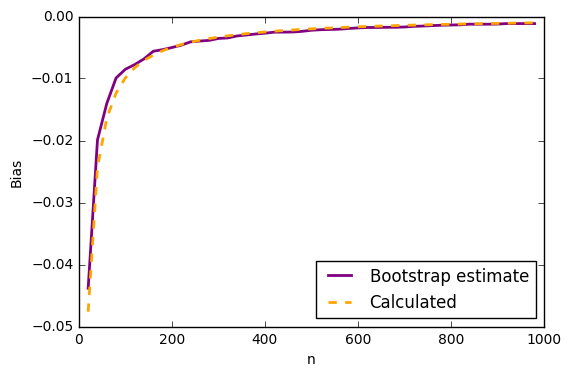

In [61]:
rolling_bias = [(i, np.mean(np.max(bootstrap_data[:, 0:i], axis=1)) - true_theta) 
                for i in range(1, bootstrap_data.shape[1]) if i % 20 == 0]
calculated_rolling_bias = [(j, -1/(j + 1)) for j in range(1, bootstrap_data.shape[1]) if j % 20 == 0]
plt.figure()
plt.plot(*zip(*rolling_bias), linewidth=2.0, color='purple', label='Bootstrap estimate')
plt.plot(*zip(*calculated_rolling_bias), linewidth=2.0, color='orange', linestyle='--', label='Calculated')
plt.xlabel('n')
plt.ylabel('Bias')
plt.legend(loc=4)
plt.show()

In [ ]:
rolling_se = [(i, np.std(np.max(bootstrap_data[:, 0:i], axis=1))) 
              for i in range(1, bootstrap_data.shape[1]) if i % 20 == 0] 
calculated_rolling_se = [(j, np)]

## Chapter 10

### Exercise 6
Out of 1919 Jewish deaths in the week before and after Passover, with 922 deaths the week before and 997 the week after test the hypothesis $H_0: \theta = 1/2$. Also construct a confidence interval.

#### (Mostly) analytic results
For a one-sided test the p-value is:

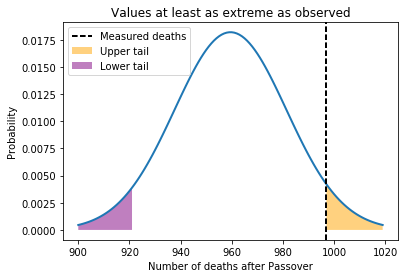

In [61]:
plt.figure()
ks = np.arange(900, 1020, 1)
dist = stats.binom.pmf(ks, 1919, .5)
plt.plot(ks, stats.binom.pmf(ks, 1919, .5), linewidth=2)
plt.fill_between(np.arange(997, 1020), stats.binom.pmf(np.arange(997, 1020), 1919, 0.5),
                 facecolor='orange', alpha=0.5, label='Upper tail')
plt.fill_between(np.arange(900, 922), stats.binom.pmf(np.arange(900, 922), 1919, 0.5),
                facecolor='purple', alpha=0.5, label='Lower tail')
plt.axvline(997, color='black', linestyle='--', linewidth=2, label='Measured deaths')
plt.title("Values at least as extreme as observed")
plt.xlabel("Number of deaths after Passover")
plt.ylabel("Probability")
plt.legend(loc=2)
plt.show()

In [6]:
p_val = 1 - stats.binom.cdf(997, 1919, .5)
p_val

0.041365258224595025

For a two sided test (i.e. to consider the possibility people are more likely to die just before a holiday than just after), I also need to add the probability in the lower tail:

In [7]:
p_val = p_val + stats.binom.cdf(922, 1919, .5)
p_val

0.086937885518616781

So the alternative hypothesis would be retained at say, the .10 level but rejected at the .05 level for a two-tailed test.  To construct a confidence interval I will use the MLE $\theta = 997/1919$ and then use the Fisher information to estimate the standard error of the estimator. 

In [26]:
est_theta = 997/1919.
def binom_se(n, theta):
    return np.sqrt((theta * (1 - theta)/n))
est_CI = (est_theta - 2*binom_se(1919, est_theta), est_theta + 2*binom_se(1919, est_theta))
est_CI

(0.49673115009089169, 0.54235170556309464)

which includes $\theta = .5$ in the 95% confidence interval.

#### Simulated results

The preceding problem can be simulated by generating many events sampled from a binomial distribution with $n=1919$ and $\theta=1/2$.  For a one-tailed test there should be approximately 4.1%  of the trials with at least 997 people surviving until the week after the holiday.  For a two-tailed test there should be about 8.7% where the deaths the week after the holiday are not in the interval $(922, 997)$.

In [24]:
data = stats.binom.rvs(1919, 0.5, size=100000)
np.mean(data >= 997)

0.045199999999999997

In [25]:
np.mean(np.logical_or(data >= 997, data <= 922))

0.090359999999999996

Similarly for the confidence intervals (with $\theta=997/1919$):

In [57]:
data = stats.binom.rvs(1919, 997/1919, size=100000)
np.mean(np.logical_or(data/1919 > est_CI[1], data/1919 < est_CI[0]))

0.047370000000000002

so just over 95% of events are in the calculated confindence interval from above.  This is to be expected since the 2 standard deviation interval will be slightly larger than a true 95% interval.